# Webscrape the East Bay for category: Rooms/Shares

In [1]:
#import get to call a get request on the site
from requests import get

In [35]:
#get the first page of the east bay housing prices
response = get('https://sfbay.craigslist.org/search/eby/apa?hasPic=1&availabilityMode=0') #get rid of those lame-o's that post a housing option without a pic using their filter

print(response.text[:500])

﻿<!DOCTYPE html>
<html class="no-js"><head>
    <title>SF bay area apts/housing for rent  - craigslist</title>

    <meta name="description" content="SF bay area apts/housing for rent  - craigslist">
    <meta http-equiv="X-UA-Compatible" content="IE=Edge"/>
    <link rel="canonical" href="https://sfbay.craigslist.org/search/eby/apa">
    <link rel="alternate" type="application/rss+xml" href="https://sfbay.craigslist.org/search/eby/apa?availabilityMode=0&amp;format=rss&amp;hasPic=1" title="RSS f


In [36]:
from bs4 import BeautifulSoup

In [37]:
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [38]:
#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 50 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [39]:
#grab the first post
post_one = posts[0]
post_one

<li class="result-row" data-pid="6799846476">
<a class="result-image gallery" data-ids="1:01111_6DqdhP4jHVN,1:00Q0Q_eHtbgkloOLS,1:00K0K_2F65gowTPuB,1:00D0D_6WVVSJ6dTWz,1:00X0X_7o4gGILsS1n,1:00000_f98eAecBM2p,1:01616_lqQSwpZk1DA,1:00909_juhZKrBPqI6,1:00l0l_d0uSDIu1dMm,1:00C0C_80NR4jAHGVl,1:00101_8Wo3O9MhR88,1:00f0f_7vPQd0H9kM4,1:00W0W_bLWcDbcuB0O,1:00w0w_9eLWmRwCWYq,1:01212_kDQjrtHWB4p" href="https://sfbay.craigslist.org/eby/apa/d/walnut-creek-condo-for-rent/6799846476.html">
<span class="result-price">$2700</span>
</a>
<p class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2019-01-20 16:13" title="Sun 20 Jan 04:13:45 PM">Jan 20</time>
<a class="result-title hdrlnk" data-id="6799846476" href="https://sfbay.craigslist.org/eby/apa/d/walnut-creek-condo-for-rent/6799846476.html">Condo for rent</a>
<span class="result-meta">
<span class="result-price">$2700</span>
<span class="

In [40]:
#grab the price of the first post
post_one_price = post_one.a.text
post_one_price

'\n$2700\n'

In [41]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

#split them and grab each element of the resulting list to get date and time
post_one_datetime = post_one_datetime.split(' ')
post_one_date = post_one_datetime[0]
post_one_date

#element 2 is the time
post_one_time = post_one_datetime[1]

post_one_time

'16:13'

In [42]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']
post_one_link

'https://sfbay.craigslist.org/eby/apa/d/walnut-creek-condo-for-rent/6799846476.html'

In [43]:
#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text
post_one_title_text

'Condo for rent'

In [44]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from that
post_one_hood = post_one.find('span', class_= 'result-hood').text
post_one_hood

' (walnut creek)'

In [45]:
#build out the loop
from time import sleep
from random import randint
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)

pages = np.arange(0, results_total, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get("https://sfbay.craigslist.org/search/eby/apt?" 
                   + "s=" 
                   + str(page) 
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)

            post_price = post.a.text
            post_prices.append(post_price)


    iterations += 1
    print("Finished iteration: " + str(iterations))

Finished iteration: 1
Finished iteration: 2
Finished iteration: 3
Finished iteration: 4
Finished iteration: 5
Finished iteration: 6
Finished iteration: 7
Finished iteration: 8
Finished iteration: 9
Finished iteration: 10
Finished iteration: 11
Finished iteration: 12
Finished iteration: 13
Finished iteration: 14
Finished iteration: 15
Finished iteration: 16
Finished iteration: 17
Finished iteration: 18
Finished iteration: 19
Finished iteration: 20
Finished iteration: 21
Finished iteration: 22
Finished iteration: 23
Finished iteration: 24
Finished iteration: 25


In [46]:
import pandas as pd

eb_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'URL': post_links,
                       'price': post_prices})
print(eb_apts.info())
eb_apts.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
posted          3000 non-null object
neighborhood    3000 non-null object
post title      3000 non-null object
URL             3000 non-null object
price           3000 non-null object
dtypes: object(5)
memory usage: 117.3+ KB
None


,posted,neighborhood,post title,URL,price
2990,2019-01-20 14:41,(hayward / castro valley),No other 3 Bedroom 2 Baths With Washer & Dryer Like This One!,https://sfbay.craigslist.org/eby/apa/d/hayward-no-other-3-bedroom-2-baths-with/6799788351.html,\n$2775\n
2991,2019-01-20 14:41,(oakland east),2 Bedroom Apartment Great Deal!!!,https://sfbay.craigslist.org/eby/apa/d/oakland-2-bedroom-apartment-great-deal/6796513781.html,\n$2395\n
2992,2019-01-20 14:40,(oakland east),"Act Now for $1,000.00 Incentive!! Stunning Studio",https://sfbay.craigslist.org/eby/apa/d/oakland-act-now-forincentive-stunning/6796505369.html,\n$1749\n
2993,2019-01-20 14:40,"(Pittsburg, CA)","Balcony or Patio, Walk In Closet, Granite Countertop",https://sfbay.craigslist.org/eby/apa/d/antioch-balcony-or-patio-walk-in-closet/6793479774.html,\n$2005\n
2994,2019-01-20 14:40,(oakland east),Affordable Luxury!! Extremely Beautiful Studio,https://sfbay.craigslist.org/eby/apa/d/oakland-affordable-luxury-extremely/6796504728.html,\n$1749\n
2995,2019-01-20 14:39,(oakland east),"Act Now for $1,000.00 Incentive!! Beautiful One Bedroom",https://sfbay.craigslist.org/eby/apa/d/oakland-act-now-forincentive-beautiful/6796436699.html,\n$1749\n
2996,2019-01-20 14:38,(oakland east),ROOM FOR RENT - Masterbedroom and Private Bath,https://sfbay.craigslist.org/eby/apa/d/oakland-room-for-rent-masterbedroom-and/6796435913.html,\n$1575\n
2997,2019-01-20 14:38,(fairfield / vacaville),"Access to pools, spas and gym with our 2 bedroom duplex",https://sfbay.craigslist.org/eby/apa/d/vacaville-access-to-pools-spas-and-gym/6799785752.html,\n$1990\n
2998,2019-01-20 14:37,(san leandro),NO RAIN THE REST OF THE WEEK!TAKE ADVANTAGE OF THE SKY & COME SAY HI!,https://sfbay.craigslist.org/eby/apa/d/san-leandro-no-rain-the-rest-of-the/6799785535.html,\n$1985\n
2999,2019-01-20 14:37,(oakland east),Availabe for move in now!! Very Beautiful Spacious Studio,https://sfbay.craigslist.org/eby/apa/d/oakland-availabe-for-move-in-now-very/6796435164.html,\n$1749\n


# Data cleaning

In [47]:
#convert datetime string into datetime object to be able to work with it
from datetime import datetime

eb_apts['posted'] = pd.to_datetime(eb_apts['posted'])
eb_apts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
posted          3000 non-null datetime64[ns]
neighborhood    3000 non-null object
post title      3000 non-null object
URL             3000 non-null object
price           3000 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 117.3+ KB


In [48]:
eb_apts['price'] = eb_apts['price'].astype(str)

In [49]:
import re

eb_apts['price'] = eb_apts['price'].apply(lambda x: re.sub(r'[\n$]+', '', x))

#replace '' with NaN values in the df before turning the column to int so data shape is maintained

In [50]:
import numpy as np
eb_apts['price'].replace('', np.nan, inplace=True)

In [51]:
#drop the NAs, I don't like them and we have a lot of data
eb_apts = eb_apts.dropna()

In [52]:
#first remove the parentheses
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: re.sub(r'[()]+', '', x))

#and the /
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: re.sub(r'[/]+', '', x))

#and commas
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: re.sub(r'[,]+', '', x)) 

In [53]:
#people spam craigslist so how many of these are unique?
eb_apts = eb_apts.drop_duplicates(subset='URL')

In [54]:
#now turn the price to int
eb_apts['price'] = eb_apts['price'].astype(int)

In [55]:
eb_apts.info() #finally a quantitative variable!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 119
Data columns (total 5 columns):
posted          118 non-null datetime64[ns]
neighborhood    118 non-null object
post title      118 non-null object
URL             118 non-null object
price           118 non-null int32
dtypes: datetime64[ns](1), int32(1), object(3)
memory usage: 5.1+ KB


In [56]:
eb_apts['neighborhood'].unique()

array([' walnut creek', ' berkeley north  hills',
       ' dublin  pleasanton  livermore', ' richmond  point  annex',
       ' pittsburg  antioch', ' emeryville',
       ' hercules pinole san pablo el sob', ' hayward  castro valley',
       ' fairfield  vacaville', ' fremont  union city  newark',
       ' brentwood  oakley', ' oakland rockridge  claremont',
       ' san leandro', ' danville  san ramon',
       ' oakland lake merritt  grand', ' alameda',
       ' oakland north  temescal', ' berkeley', ' oakland downtown',
       ' lafayette  orinda  moraga', ' concord  pleasant hill  martinez',
       ' oakland piedmont  montclair', ' oakland east',
       ' 7747 Coral Lane Stockton', ' Pittsburg CA'], dtype=object)

In [62]:
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: x.lstrip(' '))

C:\Users\riley\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


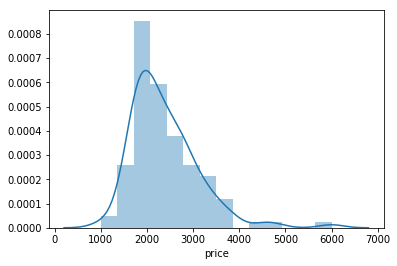

In [63]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
%matplotlib inline

#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(eb_apts['price']); #the majority of posts unfortunately 

In [69]:
pd.options.display.max_colwidth = 100 #display full URL
cheap_berkeley = eb_apts[(eb_apts['price'] < 1000) & (eb_apts['neighborhood'] == 'berkeley') |
                         (eb_apts['neighborhood'] == 'oakland piedmont  montclair') |
                         (eb_apts['neighborhood'] == 'berkeley north  hills')]
cheap_berkeley.sort_values(by='price', ascending=True)

,posted,neighborhood,post title,URL,price
79,2019-01-20 15:04:00,oakland piedmont montclair,Large courtyard view condo in Piedmont neighborhood,https://sfbay.craigslist.org/eby/apa/d/oakland-large-courtyard-view-condo-in/6792866929.html,2500
26,2019-01-20 15:41:00,berkeley north hills,"Thanks read, welcome move in",https://sfbay.craigslist.org/eby/apa/d/berkeley-thanks-read-welcome-move-in/6799821146.html,2999
1,2019-01-20 16:10:00,berkeley north hills,Kensington Home For Rent,https://sfbay.craigslist.org/eby/apa/d/el-cerrito-kensington-home-for-rent/6799844476.html,3250
